In [1]:
import sympy as sym 
from IPython.display import display

def cubic_spline(xs: list[float], ys: list[float]) -> list[sym.Symbol]:
    """
    Cubic spline interpolation ``S``. Every two points are interpolated by a cubic polynomial
    ``S_j`` of the form ``S_j(x) = a_j + b_j(x - x_j) + c_j(x - x_j)^2 + d_j(x - x_j)^3.``

    xs must be different  but not necessarily ordered nor equally spaced.

    ## Parameters
    - xs, ys: points to be interpolated

    ## Return
    - List of symbolic expressions for the cubic spline interpolation.
    """

    points = sorted(zip(xs, ys), key=lambda x: x[0])  # sort points by x

    xs = [x for x, _ in points]
    ys = [y for _, y in points]

    n = len(points) - 1  # number of splines

    h = [xs[i + 1] - xs[i] for i in range(n)]  # distances between  contiguous xs

    alpha = [0]*n
    for i in range(1, n):
        alpha[i] = 3 / h[i] * (ys[i + 1] - ys[i]) - 3 / h[i - 1] * (ys[i] - ys[i - 1])

    l = [1]
    u = [0]
    z = [0]

    for i in range(1, n):
        l += [2 * (xs[i + 1] - xs[i - 1]) - h[i - 1] * u[i - 1]]
        u += [h[i] / l[i]]
        z += [alpha[i] - h[i - 1] * z[i - 1] / l[i]] 

    l.append(1)
    z.append(0)
    c = [0] * (n + 1)

    x = sym.Symbol("x")
    splines = []
    for j in range(n - 1, -1, -1):
        c[j] = z[j] - u[j] * c[j + 1]
        b = (ys[j + 1] - ys[j]) / h[j] - h[j] * (c[j + 1] + 2 * c[j]) / 3
        d = (c[j + 1] - c[j]) / (3 * h[j])
        a = ys[j]
        print(j, a, b, c[j], d)
        S = a + b * (x - xs[j]) + c[j] * (x - xs[j])**2 + d * (x - xs[j])**3

        splines.append(S)
    splines.reverse()
    return splines

In [4]:
xs = [0, 1, 2]
ys = [-5, -4, 3]

splines = cubic_spline(xs=xs, ys=ys)
_ = [display(s) for s in splines]
print("______")
_ = [display(s.expand()) for s in splines]

1 -4 -5.0 18.0 -6.0
0 -5 -5.0 0.0 6.0


6.0*x**3 - 5.0*x - 5

-5.0*x - 6.0*(x - 1)**3 + 18.0*(x - 1)**2 + 1.0

______


6.0*x**3 - 5.0*x - 5

-6.0*x**3 + 36.0*x**2 - 59.0*x + 25.0

## Ejercicio 4

In [2]:
xs = [1, 2, 3]
ys = [2, 3, 5]

splines = cubic_spline(xs=xs, ys=ys)
_ = [display(s) for s in splines]
print("______")
_ = [display(s.expand()) for s in splines]

1 3 0.0 3.0 -1.0
0 2 0.0 0.0 1.0


1.0*(x - 1)**3 + 2

-1.0*(x - 2)**3 + 3.0*(x - 2)**2 + 3

______


1.0*x**3 - 3.0*x**2 + 3.0*x + 1.0

-1.0*x**3 + 9.0*x**2 - 24.0*x + 23.0

## Ejercicio 5

In [3]:
xs = [0, 1, 2, 3]
ys = [-1, 1, 5, 2]

splines = cubic_spline(xs=xs, ys=ys)
_ = [display(s) for s in splines]
print("______")
_ = [display(s.expand()) for s in splines]

2 5 12.066666666666668 -22.6 7.533333333333334
1 1 3.766666666666667 11.65 -11.416666666666666
0 -1 -1.8833333333333333 0.0 3.8833333333333333


3.88333333333333*x**3 - 1.88333333333333*x - 1

3.76666666666667*x - 11.4166666666667*(x - 1)**3 + 11.65*(x - 1)**2 - 2.76666666666667

12.0666666666667*x + 7.53333333333333*(x - 2)**3 - 22.6*(x - 2)**2 - 19.1333333333333

______


3.88333333333333*x**3 - 1.88333333333333*x - 1

-11.4166666666667*x**3 + 45.9*x**2 - 53.7833333333333*x + 20.3

7.53333333333333*x**3 - 67.8*x**2 + 192.866666666667*x - 169.8

# Frontera condicionada

In [10]:
import sympy as sym
from IPython.display import display
import matplotlib as plt


# ###################################################################
def cubic_spline_clamped(
    xs: list[float], ys: list[float], d0: float, dn: float
) -> list[sym.Symbol]:
    """
    Cubic spline interpolation ``S``. Every two points are interpolated by a cubic polynomial
    ``S_j`` of the form ``S_j(x) = a_j + b_j(x - x_j) + c_j(x - x_j)^2 + d_j(x - x_j)^3.``

    xs must be different  but not necessarily ordered nor equally spaced.

    ## Parameters
    - xs, ys: points to be interpolated
    - d0, dn: derivatives at the first and last points

    ## Return
    - List of symbolic expressions for the cubic spline interpolation.
    """

    points = sorted(zip(xs, ys), key=lambda x: x[0])  # sort points by x
    xs = [x for x, _ in points]
    ys = [y for _, y in points]
    n = len(points) - 1  # number of splines
    h = [xs[i + 1] - xs[i] for i in range(n)]  # distances between  contiguous xs

    alpha = [0] * (n + 1)  # prealloc
    alpha[0] = 3 / h[0] * (ys[1] - ys[0]) - 3 * d0
    alpha[-1] = 3 * dn - 3 / h[n - 1] * (ys[n] - ys[n - 1])

    for i in range(1, n):
        alpha[i] = 3 / h[i] * (ys[i + 1] - ys[i]) - 3 / h[i - 1] * (ys[i] - ys[i - 1])

    l = [2 * h[0]]
    u = [0.5]
    z = [alpha[0] / l[0]]

    for i in range(1, n):
        l += [2 * (xs[i + 1] - xs[i - 1]) - h[i - 1] * u[i - 1]]
        u += [h[i] / l[i]]
        z += [(alpha[i] - h[i - 1] * z[i - 1]) / l[i]]

    l.append(h[n - 1] * (2 - u[n - 1]))
    z.append((alpha[n] - h[n - 1] * z[n - 1]) / l[n])
    c = [0] * (n + 1)  # prealloc
    c[-1] = z[-1]

    x = sym.Symbol("x")
    splines = []
    for j in range(n - 1, -1, -1):
        c[j] = z[j] - u[j] * c[j + 1]
        b = (ys[j + 1] - ys[j]) / h[j] - h[j] * (c[j + 1] + 2 * c[j]) / 3
        d = (c[j + 1] - c[j]) / (3 * h[j])
        a = ys[j]
        print(j, a, b, c[j], d)
        S = a + b * (x - xs[j]) + c[j] * (x - xs[j]) ** 2 + d * (x - xs[j]) ** 3

        splines.append(S)
    splines.reverse()
    return splines

In [11]:
# Curva 1
x1 = [1, 2, 5, 6, 7, 8, 10, 13, 17]
y1 = [3.0, 3.7, 3.9, 4.2, 5.7, 6.6, 7.1, 6.7, 4.5]
d01 = 1.0
dn1 = -0.67

# Curva 2 
x2 = [17, 20, 23, 24, 25, 27, 27.7]
y2 = [4.5, 7.0, 6.1, 5.6, 5.8, 5.2, 4.1]
d02 = 3.0
dn2 = -4.0

# Curva 3
x3 = [27.7, 28, 29, 30]
y3 = [4.1, 4.3, 4.1, 3.0]
d03 = 0.33
dn3 = -1.5


In [12]:
# Curva 1
splines1 = cubic_spline_clamped(x1, y1, d01, dn1)
print("Splines de la Curva 1:")
for s in splines1:
    display(s)

# Curva 2 
splines2 = cubic_spline_clamped(x2, y2, d02, dn2)
print("\nSplines de la Curva 2:")
for s in splines2:
    display(s)

# Curva 3
splines3 = cubic_spline_clamped(x3, y3, d03, dn3)
print("\nSplines de la Curva 3:")
for s in splines3:
    display(s)


7 6.7 -0.3381314976116886 -0.07593425119415571 0.0057417813992694635
6 7.1 0.04846024164091059 -0.052929661890044014 -0.0025560654782346335
5 6.6 0.5472201929380908 -0.19645031375854607 0.023920108644750342
4 5.7 1.4091093003652708 -0.665438793668634 0.15632949330336265
3 4.2 1.0163426056008245 1.0582054884330803 -0.5745480940339047
2 3.9 -0.07447972276856785 0.03261683993631198 0.3418628828322561
1 3.7 0.4468099653460711 -0.20638006930785827 0.02655521213824114
0 3.0 1.0 -0.3468099653460706 0.046809965346070785
Splines de la Curva 1:


1.0*x + 0.0468099653460708*(x - 1)**3 - 0.346809965346071*(x - 1)**2 + 2.0

0.446809965346071*x + 0.0265552121382411*(x - 2)**3 - 0.206380069307858*(x - 2)**2 + 2.80638006930786

-0.0744797227685678*x + 0.341862882832256*(x - 5)**3 + 0.032616839936312*(x - 5)**2 + 4.27239861384284

1.01634260560082*x - 0.574548094033905*(x - 6)**3 + 1.05820548843308*(x - 6)**2 - 1.89805563360495

1.40910930036527*x + 0.156329493303363*(x - 7)**3 - 0.665438793668634*(x - 7)**2 - 4.1637651025569

0.547220192938091*x + 0.0239201086447503*(x - 8)**3 - 0.196450313758546*(x - 8)**2 + 2.22223845649527

0.0484602416409106*x - 0.00255606547823463*(x - 10)**3 - 0.052929661890044*(x - 10)**2 + 6.61539758359089

-0.338131497611689*x + 0.00574178139926946*(x - 13)**3 - 0.0759342511941557*(x - 13)**2 + 11.095709468952

5 5.2 -0.4011781849199465 0.1258152222202451 -2.568002126658778
4 5.8 0.1539868142803838 -0.4033977218204103 0.08820215734010924
3 5.6 -0.11137135038117751 0.6687558864819717 -0.35738453610079396
2 6.1 -0.6085014127556733 -0.17162582410747595 0.2801272368631492
1 7.0 -0.19787464681108174 0.03475023545927881 -0.022930673285194974
0 4.5 3.0 -1.1007084510629728 0.12616207628025017

Splines de la Curva 2:


3.0*x + 0.12616207628025*(x - 17)**3 - 1.10070845106297*(x - 17)**2 - 46.5

-0.197874646811082*x - 0.022930673285195*(x - 20)**3 + 0.0347502354592788*(x - 20)**2 + 10.9574929362216

-0.608501412755673*x + 0.280127236863149*(x - 23)**3 - 0.171625824107476*(x - 23)**2 + 20.0955324933805

-0.111371350381178*x - 0.357384536100794*(x - 24)**3 + 0.668755886481972*(x - 24)**2 + 8.27291240914826

0.153986814280384*x + 0.0882021573401092*(x - 25)**3 - 0.40339772182041*(x - 25)**2 + 1.9503296429904

-0.401178184919947*x - 2.56800212665878*(x - 27)**3 + 0.125815222220245*(x - 27)**2 + 16.0318109928386

2 4.1 -0.7653465346534649 -0.26930693069306927 -0.06534653465346556
1 4.3 0.6613861386138599 -1.1574257425742556 0.2960396039603954
0 4.1 0.3299999999999999 2.2620462046204524 -3.799413274660778

Splines de la Curva 3:


0.33*x - 80752.4751789508*(0.036101083032491*x - 1)**3 + 1735.64543234323*(0.036101083032491*x - 1)**2 - 5.041

0.66138613861386*x + 0.296039603960395*(x - 28)**3 - 1.15742574257426*(x - 28)**2 - 14.2188118811881

-0.765346534653465*x - 0.0653465346534656*(x - 29)**3 - 0.269306930693069*(x - 29)**2 + 26.2950495049505

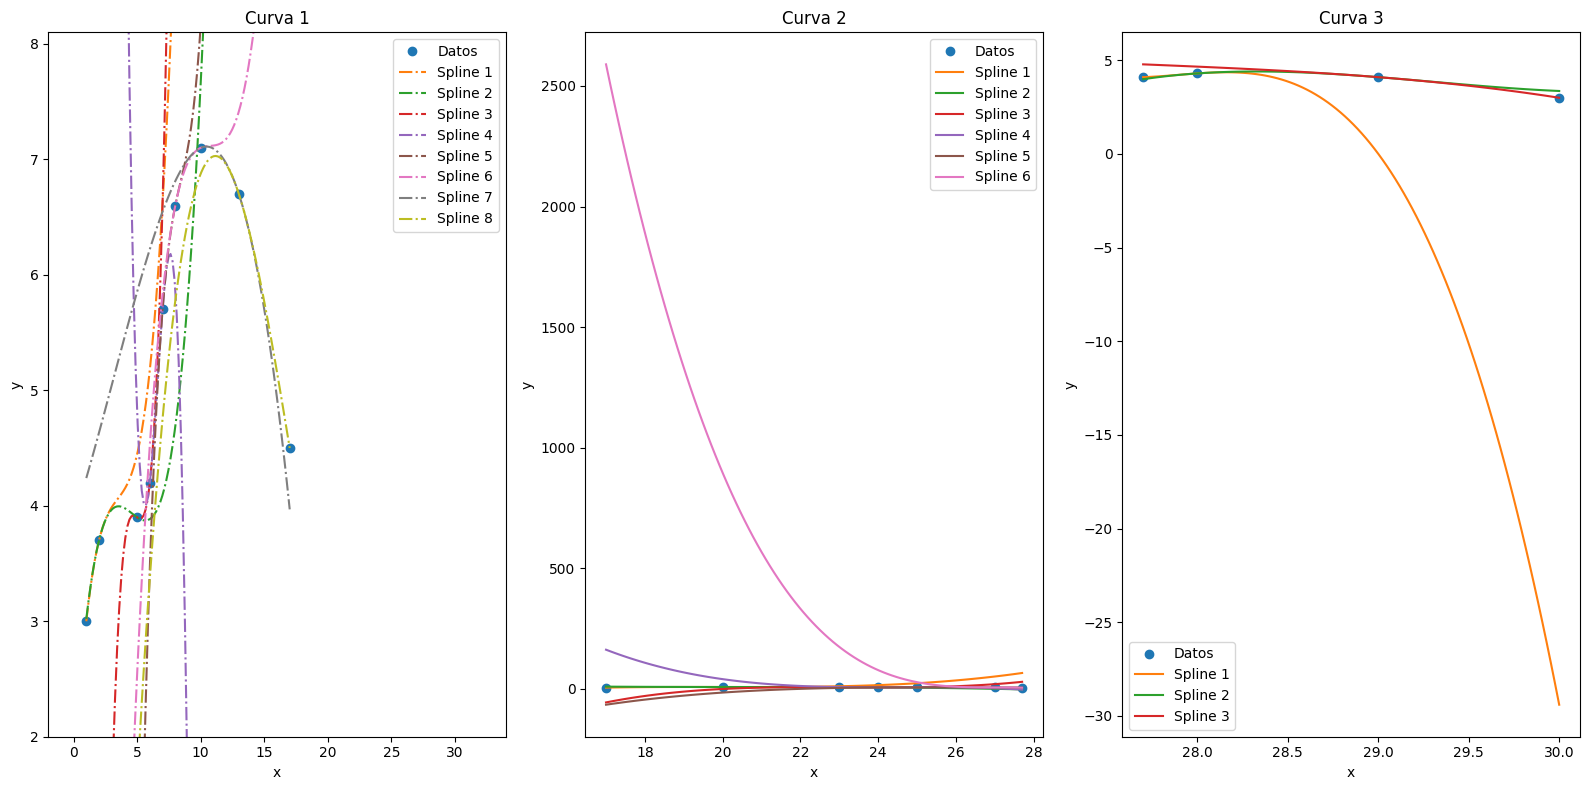

In [54]:
import numpy as np
# Gráfica de la curva 1
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.plot(x1, y1, 'o', label='Datos')
x = sym.Symbol('x')
spline_count = 1
for s in splines1:
    x_plot = np.linspace(x1[0], x1[-1], 100)
    y_plot = [s.subs(x, xi) for xi in x_plot]
    plt.plot(x_plot, y_plot, label=f'Spline {spline_count}', linestyle="-.")
    spline_count += 1
plt.title('Curva 1')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-2 * x1[0], 2 * x1[-1])
plt.ylim(min(y1) - 1, max(y1) + 1)
plt.legend()

# Graficar Curva 2
plt.subplot(1, 3, 2)
plt.plot(x2, y2, 'o', label='Datos')
x = sym.Symbol('x')
spline_count = 1
for s in splines2:
    x_plot = np.linspace(x2[0], x2[-1], 100)
    y_plot = [s.subs(x, xi) for xi in x_plot]
    plt.plot(x_plot, y_plot, label=f'Spline {spline_count}')
    spline_count += 1
plt.title('Curva 2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Graficar Curva 3
plt.subplot(1, 3, 3)
plt.plot(x3, y3, 'o', label='Datos')
x = sym.Symbol('x')
spline_count = 1
for s in splines3:
    x_plot = np.linspace(x3[0], x3[-1], 100)
    y_plot = [s.subs(x, xi) for xi in x_plot]
    plt.plot(x_plot, y_plot, label=f'Spline {spline_count}')
    spline_count += 1
plt.title('Curva 3')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()